# Introduction

This script was created for the CCC: Graphs project at Loughborough University.

In order execute it, a csv file named `data.csv` must be placed in the same directory as this file. The csv file must contain the following columns: __group, pre, post, delayed__.

| group | pre | post | delayed |
| --- | --- | --- | --- |
| 0 | 3 | 10 | 7 |
| 0 | 4 | 15 | 9 |
| 1 | 2 | 13 | 8 |
| 1 | 4 | 14 | 10 |

The __group__ column is a `[0, 1]` dummy variable indicating whether the participant is in the control or experimental group respectively.

The __pre, post__ and __delayed__ columns are measurements taken before the intervention, a day after the intervention and a week after the intervention respectively.

In order to run this script you must have the following modules installed:
* matplotlib
* numpy
* pandas
* sklearn
* scipy
* pinguin
* seaborn
* statsmodels

To install these modules enter `pip install matplotlib numpy pandas sklearn scipy pinguin` into your terminal.

Commonly used abbreviations include:
* __experimental__ -> `exp`
* __control__ -> `ctr`
* __data frame__ -> `df`
* __figure__ -> `fig`
* __axis__ -> `ax`

# Imports, Global Variables and Functions

In [1]:
from collections import OrderedDict
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pingouin import ancova, anova, kruskal
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf

EXP_COLOR = 'grey'
CTR_COLOR = 'white'

# The ordered dict is a hash map that allows for consistent iteration over both its keys and values
# This is very convenient for drawing graphs and accessing columns in the dataframe.
TESTS = OrderedDict((('pre', 'Pre-test'), ('post', 'Post-test'), ('delayed', 'Delayed Post-test')))

# Saving a figure takes a while which can slow down calculations. Set this to true only when you
# want to actually save figures.
SAVE_FIG = False

# selecting an apa to format figures style sheet
matplotlib.style.use(
    matplotlib.get_data_path() + '/stylelib/apa.mplstyle'
)

In [2]:
# creates the directory "figures"
try:
    os.mkdir(
        os.path.join('.', 'figures'))
except FileExistsError:
    pass


def save_fig(filename):
    """
    A function that saves the current plt.Figure object as an svg.
    """
    if not SAVE_FIG:
        return
    file_path = os.path.join('.', 'figures', f'{filename}.svg')
    plt.savefig(file_path, bbox_inches='tight')

# Fetching the Data

In [3]:
df = pd.read_csv('study-data.csv')

# Inspecting the Data

In [4]:
df.head()

,student_id,group,pre,post,delayed,dropout,notes
0,1001,NaN,NaN,NaN,NaN,NaN,NaN
1,1002,0.0,0.0,4.0,NaN,1.0,Dropout at participant's request
2,1003,1.0,11.0,NaN,31.0,1.0,Dropout at participant's request
3,1004,0.0,21.0,36.0,48.0,NaN,NaN
4,1005,1.0,40.0,48.0,48.0,NaN,NaN


In [5]:
df.describe()

,student_id,group,pre,post,delayed,dropout
count,300.000000,230.000000,229.000000,217.000000,175.000000,6.0
mean,3065.500000,0.530435,5.157205,17.502304,19.988571,1.0
std,1417.488092,0.500161,9.708998,13.163194,14.415425,0.0
min,1001.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2015.750000,0.000000,0.000000,6.000000,7.500000,1.0
50%,3065.500000,1.000000,0.000000,16.000000,18.000000,1.0
75%,4115.250000,1.000000,6.000000,27.000000,30.500000,1.0
max,5130.000000,1.000000,48.000000,48.000000,48.000000,1.0


## Drop Participants

In [6]:
# Drop all rows with a missing pre-test data

missing = df.index[df['pre'].isna()]
df.drop(missing, inplace=True)

In [7]:
# Drop all rows with a 'dropout' value of 1

dropout = df.index[df['dropout'] == 1]
df.drop(dropout, inplace=True)

In [8]:
# Splitting the data into the control and experimental sets

exp = df[df['group'] == 1]
ctr = df[df['group'] == 0]

# Checking That the Assumptions of the Data for an ANCOVA Are Met

The assumptions of the data for an ANCOVA are:


1. __Independent observations__. This condition is met as the student in each class independently sit their pre- and post-test at the same time.


2. __Normality of the dependent variable__. This condition can be relaxed a little if the data is approximately normal. To avoid a ceiling effect, the tests have been designed to so that they are almost impossible to complete in the allotted time.


3. __Homogeneity__. This condition is particularly important if there are sharply unequal sample sizes. I intend for both groups to be of equal sizes, but dropout may result in unequal group sizes.


4. __Homogeneity of regression slopes__. This condition is likely to be met since students are randomly allocated to a group at the individual level.


5. __Linearity__. 

In [9]:
df.describe()

,student_id,group,pre,post,delayed,dropout
count,224.00000,224.00000,224.000000,213.000000,171.000000,0.0
mean,3120.03125,0.53125,5.035714,17.586854,19.883041,NaN
std,1461.73814,0.50014,9.474468,12.976692,14.349761,NaN
min,1004.00000,0.00000,0.000000,0.000000,0.000000,NaN
25%,2015.75000,0.00000,0.000000,6.000000,7.500000,NaN
50%,3065.50000,1.00000,0.000000,16.000000,18.000000,NaN
75%,4125.50000,1.00000,6.000000,27.000000,30.000000,NaN
max,5130.00000,1.00000,48.000000,48.000000,48.000000,NaN


## Sample Sizes and Descriptive Statistics

If the sample size is sufficiently large (`n > 30`), a moderate departure from normality can be allowed.

In [10]:
# Sample sizes

df.groupby('group').count()

,student_id,pre,post,delayed,dropout,notes
group,,,,,,
0.0,105,105,99,79,0,8
1.0,119,119,114,92,0,8


In [11]:
# Mean test scores

df.groupby('group').mean()[TESTS.keys()]

,pre,post,delayed
group,,,
0.0,5.009524,16.030303,17.822785
1.0,5.058824,18.938596,21.652174


In [12]:
# Standard deviation of test scores

df.groupby('group').std()[TESTS.keys()]

,pre,post,delayed
group,,,
0.0,9.338192,12.508327,14.660045
1.0,9.632479,13.276691,13.914523


In [13]:
len(df[df['pre'] > 45]) / len(df)

0.004464285714285714

## Drawing a Histrogram to inspect Distribution

In [14]:
def calculate_bins(x):
    """
    Uses the Freedman-Diaconis rule to determine the number of bins in a histogram
    https://en.wikipedia.org/wiki/Freedman–Diaconis_rule

    Args:
        x (array): the data used to draw a histogram

    Returns:
        int: the number of bins to be used in a histogram
    """
    x = np.array(x)                                  # Convert x to numpy array
    x = x[~np.isnan(x)]                              # Drop NaN value
    q25, q75 = np.percentile(x, [25, 75])            # Calculate lower and upper quartiles
    bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)   # Freedman-Diaconis formula for bin width
    return round((x.max() - x.min()) / bin_width)    # Divide range by bin_width for num_bins

/Users/jacob/miniforge3/envs/mlp/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


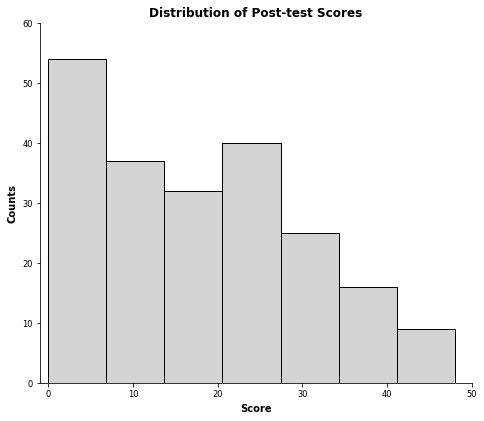

In [15]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0, 0, 1, 1])

test = 'post'

ax.hist(
    df[test], 
    bins=calculate_bins(df[test]),
    edgecolor='black',
    color='lightgrey'
)

ax.set_xlabel('Score')
ax.set_ylabel('Counts')
ax.set_title('Distribution of Post-test Scores')

ax.set_xlim(-1, 50)

save_fig('post_test_distribution')

## Drawing Plot to Get a Visual Assessment of the App’s Effect

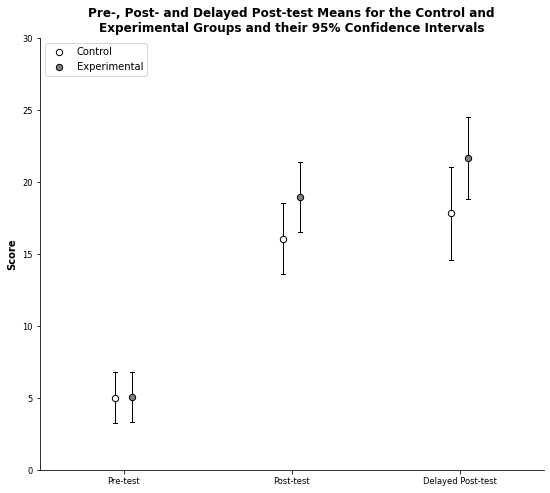

In [16]:
means = df.groupby('group').mean()[TESTS.keys()]
std = df.groupby('group').std()[TESTS.keys()]
counts = df.groupby('group').count()[TESTS.keys()]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0, 0, 1, 1])

colors = [CTR_COLOR, EXP_COLOR]
labels = ['Control', 'Experimental']

args = {
    'color': 'black', 
    'linewidth': 1,
    'linestyle': '-'
}
line_width = 0.025

for i in range(2):
    for x, (m, s, c) in enumerate(zip(means.iloc[i], std.iloc[i], counts.iloc[i])):
        x = x + 0.05 if i else x - 0.05
        
        # Calculate 95% confidence interval
        ci95 = 1.96 * s / math.sqrt(c)    
        
        # Defining the position of the error bars
        left = x - line_width / 2
        top = m - ci95
        right = x + line_width / 2
        bottom = m + ci95
        
        # Plotting the points and the error bars
        ax.plot([x, x], [top, bottom], **args)
        ax.plot([left, right], [top, top], **args)
        ax.plot([left, right], [bottom, bottom], **args)
        ax.scatter(
            x, m,
            color=colors[i],
            s=40,
            label=labels[i] if -0.1 < x < 0.1  else "",
            edgecolor='black',
            zorder=3
        ) 

# Format the plot
ax.set_ylabel('Score')
ax.set_title('Pre-, Post- and Delayed Post-test Means for the Control and\nExperimental Groups and their 95% Confidence Intervals')

# Set ticks and show legend
plt.xticks([0, 1, 2], TESTS.values())
plt.legend(loc="upper left")

# Save the figure
save_fig('effectiveness_scatter_plot')

## Drawing Frequency Distributions of the Test Scores

In [17]:
def draw_histogram(exp, ctr, bins=None):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_axes([0, 0, 0.48, 1])
    ax2 = fig.add_axes([0.52, 0, 0.48, 1])
    test_name = TESTS[exp.name]
    
    exp_bins = bins if bins else calculate_bins(exp)
    ctr_bins = bins if bins else calculate_bins(exp)
    
    exp_counts, _, _ = ax1.hist(
        exp, 
        bins=exp_bins,
        edgecolor='black',
        color=EXP_COLOR
    )
    
    ctr_counts, _, _ = ax2.hist(
        ctr, 
        bins=ctr_bins, 
        edgecolor='black',
        color=CTR_COLOR,
    )
    
    ax1.set_xlabel(f'{test_name} Score')
    ax1.set_ylabel('Count')
    ax1.set_title(f'Distribution of {test_name}\nScores for Experimental Group')
    
    ax2.set_xlabel(f'{test_name} Score')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Distribution of {test_name}\nScores for Control Group')
    
    max_score = max(max(exp), max(ctr))
    max_count = max(max(exp_counts), max(ctr_counts))
    
    for ax, mean in zip((ax1, ax2), (exp.mean(), ctr.mean())):
        ax.set_xlim([0, max_score + 3])
        ax.set_ylim([0, max_count + 3])
        ax.plot([mean, mean], [0, max_count], label='mean', color='#333333', ls='--')
        ax.legend()
    
    return plt

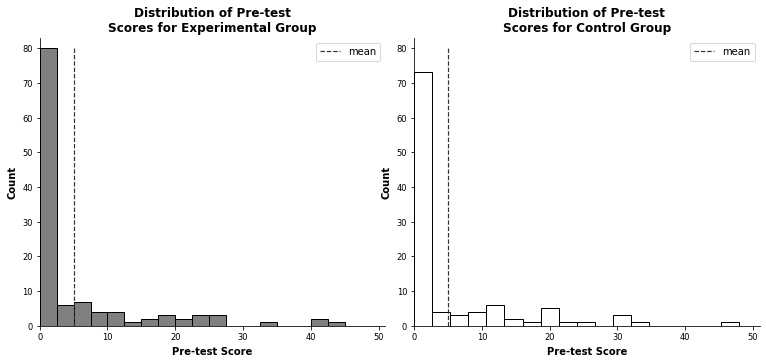

In [18]:
draw_histogram(exp['pre'].dropna(), ctr['pre'].dropna())
save_fig('pre-test_distribution')

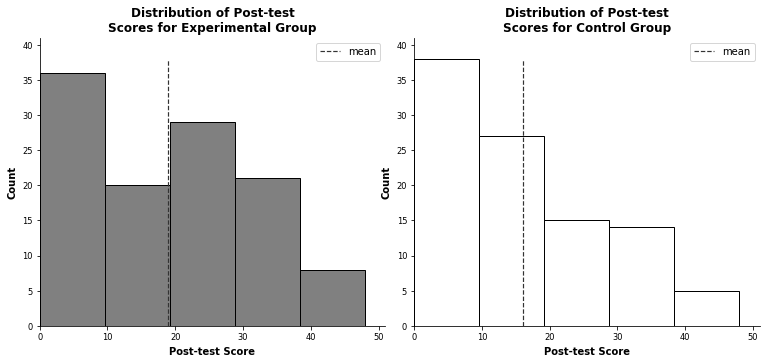

In [19]:
draw_histogram(exp['post'].dropna(), ctr['post'].dropna())
save_fig('post-test_distribution')

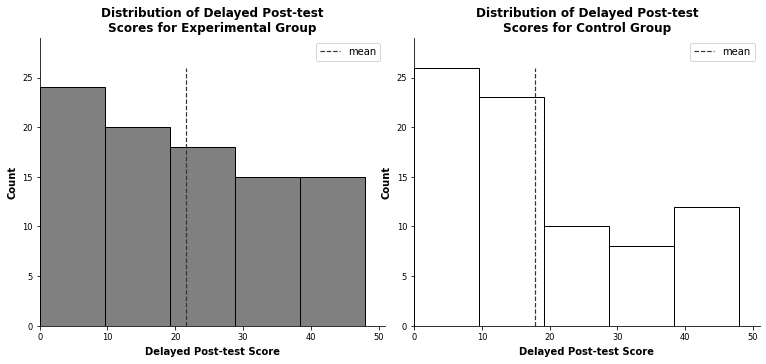

In [20]:
draw_histogram(exp['delayed'].dropna(), ctr['delayed'].dropna())
save_fig('delayed_test_distribution')

## Running Shapiro-Wilk Test to Test the Assumption of Normality

The Shapiro-Wilk test tests the normality of residuals. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html for more details.

In [21]:
res = {}
ks_statistics = {}
p_values = {}

for sample, group in zip((exp, ctr), ('Experimental', 'Control')):
    for col, test in TESTS.items():
        statistic, p_value = stats.shapiro(sample[col].dropna())
        ks_statistics[(group, test)] = statistic
        p_values[(group, test)] = p_value
        
res['Statistic'] = ks_statistics
res['p_value'] = p_values
    
pd.DataFrame.from_dict(res)

Statistic       p_value
Experimental Pre-test            0.603217  1.962577e-16
             Post-test           0.951935  4.420230e-04
             Delayed Post-test   0.956735  3.927988e-03
Control      Pre-test            0.614838  3.468302e-15
             Post-test           0.935943  1.192586e-04
             Delayed Post-test   0.905835  2.417413e-05

## Conducting a T-test to Establish Independence of the Covariate and the Treatment Group

In [22]:
t_test = stats.ttest_ind(exp['pre'], ctr['pre'])
print(t_test)
pd.DataFrame(data=[t_test], columns=['statistic', 'p_value'], index=['Pre-test'])

Ttest_indResult(statistic=0.03877566793579145, pvalue=0.9691040914768562)


,statistic,p_value
Pre-test,0.038776,0.969104


## Running Levene’s Test to Test the Assumption of Homogeneity of Variance


The Levene test tests the null hypothesis that all input samples are from populations with equal variances. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html for more details

In [23]:
res = {}

for col, test in TESTS.items():
    res[test] = stats.levene(exp[col].dropna(), ctr[col].dropna(), center='mean')
    
pd.DataFrame.from_dict(res, orient='index')

,statistic,pvalue
Pre-test,0.000084,0.992675
Post-test,0.919212,0.338779
Delayed Post-test,0.180008,0.671906


## Insptecting the Data for a Linear Relationship Between the Covariate and the Dependent Variables

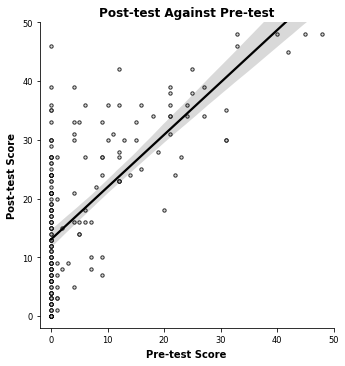

In [24]:
OUTCOME = 'post'

label_ = f"{OUTCOME.title()}-test" if OUTCOME == 'post' else f"{OUTCOME.title()} Post-test"

sns.lmplot(
    x='pre', 
    y=OUTCOME, 
    data=df,
    scatter_kws={'color': 'lightgrey', 'edgecolor': 'black', 's': 11},
    height=5
)

plt.title(f"{label_} Against Pre-test")
plt.xlabel('Pre-test Score')
plt.ylabel(f'{label_} Score')

plt.xlim(-2, 50)
plt.ylim(-2, 50)

save_fig(f"Linear Model Plot - {label_} Against Pre")

In [25]:
def draw_scatter(x, y):
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_axes([0, 0, 0.45, 1])
    ax2 = fig.add_axes([0.55, 0, 0.45, 1])
    
    max_score = max(map(max, (exp[x], exp[y], ctr[x], ctr[y])))
    
    for ax, group, color in zip((ax1, ax2), (exp, ctr), (EXP_COLOR, CTR_COLOR)):
        ax.scatter(
            x=group[x], 
            y=group[y], 
            color=color,
            edgecolor='black'
        )
        plot = "Experimental" if color == EXP_COLOR else "Control"
        
        ax.set_xlabel(TESTS[x])
        ax.set_ylabel(TESTS[y])
        ax.set_title(f'{plot} Group')

        ax.set_xlim([-2, 50])
        ax.set_ylim([-2, 50])

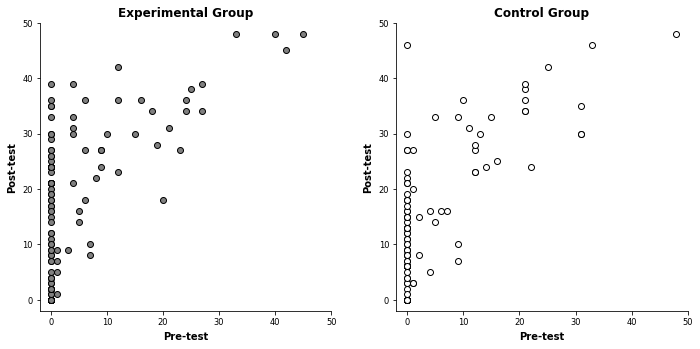

In [26]:
draw_scatter('pre', 'post')
save_fig('pre-post_scatter')

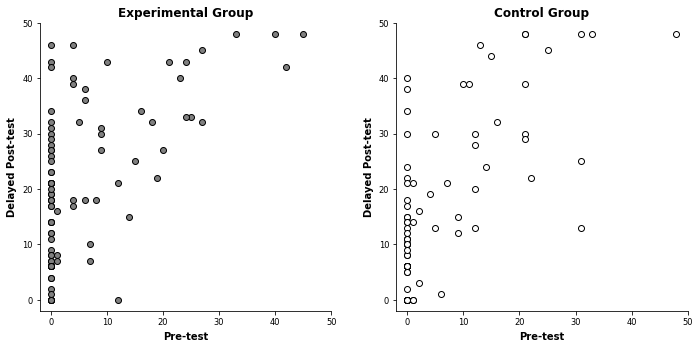

In [27]:
draw_scatter('pre', 'delayed')
save_fig('pre-delayed_scatter')

In the code below, I cross-validated the data to three different models - linear, log, and polnomial - and determine whether there are statistically significant differences in the residuals between the models.

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

n_splits = 10

# prepare the cross-validation procedure
cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)

OUTCOME = 'post'
    
for group in range(2):
    data = []
    
    for model_type in ('linear', 'log', 'x2'):
        model = LinearRegression()
        
        frame = df[~df[OUTCOME].isna()]
        X = frame[frame['group'] == group]['pre'].to_numpy().reshape(-1, 1)
        y = frame[frame['group'] == group][OUTCOME].to_numpy().reshape(-1, 1)

        if model_type == 'log':
            X = np.log(X + 1)
            X = X.reshape(-1, 1)

        if model_type.startswith('x'):
            poly = PolynomialFeatures(degree=int(model_type[-1]))
            X = poly.fit_transform(X)

        scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        data.append(scores)
        print(
            model_type, '\t', round(np.mean(scores), 2), round(scores.min(), 2), round(scores.max(), 2)
        )

    # Checking if there are statistically significant differences between residuals
    data = np.array(data)
    index = np.array([np.ones(n_splits) * i for i in range(len(data))])

    frame = pd.DataFrame(
        data={"data": data.flatten(), "group": index.flatten()}
    )

    print('\n', kruskal(data=frame, dv='data', between='group'))
    print('\n-----------------------\n')

linear 	 -78.97 -195.5 -40.27
log 	 -79.88 -198.49 -26.02
x2 	 -78.88 -222.44 -34.71

         Source  ddof1         H     p-unc
Kruskal  group      2  0.110968  0.946027

-----------------------

linear 	 -112.0 -175.14 -57.91
log 	 -114.51 -152.71 -77.83
x2 	 -111.42 -172.54 -66.41

         Source  ddof1        H     p-unc
Kruskal  group      2  0.28129  0.868798

-----------------------



## Drawing Regression Lines for Treatment Groups to Inspect the Homogeneity of Regression Slopes and Linearity

In [29]:
def regression_homogeneity(col, ax):
    for group, color in zip((exp, ctr), (EXP_COLOR, CTR_COLOR)):
        x, y = np.array(group['pre']), np.array(group[col])
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        m, c = np.polyfit(x, y, deg=1)
        
        ax.scatter(
            x, y, 
            color=color, 
            edgecolor='black',
            alpha=0.7,
            label='Experimental' if color == EXP_COLOR else "Control"
        )
        
        ax.axline(
            (0, c), 
            slope=m, 
            color='black',
            linestyle='-' if color == EXP_COLOR else "--",
            label='Experimental' if color == EXP_COLOR else "Control"
        )
        
    ax.set_xlabel=f"{TESTS['pre']} Score"
    ax.set_ylabel=f"{TESTS[col]} Score"
    ax.set_title(f"{TESTS[col]} Score Against\n{TESTS['pre']} Score")
    
    ax.set_xlim(-2, 50)
    ax.set_ylim(-2, 50)
        
    ax.legend()

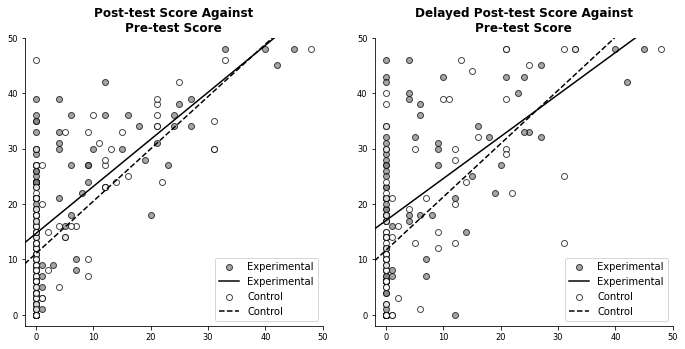

In [30]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0, 0, 0.46, 1])
ax2 = fig.add_axes([0.54, 0, 0.46, 1])

regression_homogeneity('post', ax=ax1)
regression_homogeneity('delayed', ax=ax2)

save_fig('regression_homogeneity')

## Conducting an ANOVA to Investigate the Homogeneity of Regression Slopes (Covariate Coefficients)

There should be no interaction between the categorical independent variable and covariate. This can be tested using interaction terms between groups and their pre-test scores in an ANOVA. 

We begin by creating an Ordinary Least Squares regression model, with the Post-test scores (dependent variable) explained by the interaction between the Pre-test scores (covariate) and the group dummy variable.

In [31]:
mlr_post = smf.ols(formula="post ~ pre*group", data=df).fit()
mlr_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   post   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     56.93
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           6.09e-27
Time:                        11:20:41   Log-Likelihood:                -784.07
No. Observations:                 213   AIC:                             1576.
Df Residuals:                     209   BIC:                             1590.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0800      1.113      9.956      0.000       8.886      13.274
pre            0.9443      0.103      9.206      0.000       0.742       1.146
group          3.6205      1.511      2.396      0.017       0.641       6.600
pre:group     -0.0952      0.139     -0.683      0.495      -0.370       0.179
==============================================================================
Omnibus:                        6.687   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.919
Skew:                           0.433   Prob(JB):                       0.0314
Kurtosis:                       2.830   Cond. No.                         33.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
mlr_delayed = smf.ols(formula="delayed ~ pre*group", data=df).fit()
mlr_delayed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                delayed   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     37.38
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           1.55e-18
Time:                        11:20:41   Log-Likelihood:                -653.71
No. Observations:                 171   AIC:                             1315.
Df Residuals:                     167   BIC:                             1328.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6652      1.485      7.854      0.000       8.733      14.597
pre            0.9614      0.123      7.829      0.000       0.719       1.204
group          5.3580      2.009      2.667      0.008       1.392       9.324
pre:group     -0.2036      0.166     -1.226      0.222      -0.532       0.124
==============================================================================
Omnibus:                        4.836   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.847
Skew:                           0.410   Prob(JB):                       0.0886
Kurtosis:                       2.911   Cond. No.                         38.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Next we assess homogeneity by conducting a __Wald Test__ with null hypothesis:



> The coefficient of the interaction between the pre-test scores and group membership is equal to zero.

If we __reject__ this null hypothesis then the linear regression intercepts and or slopes are not homogenous.

In [33]:
# Wald test: post-test

waldtest = mlr_post.wald_test(r_matrix='pre:group = 0', use_f=True)
print(waldtest)

<F test: F=array([[0.46704985]]), p=0.4951044398892902, df_denom=209, df_num=1>


/Users/jacob/miniforge3/envs/mlp/lib/python3.8/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [34]:
# Wald test: delayed post-test

waldtest = mlr_delayed.wald_test(r_matrix='pre:group = 0', use_f=True)
print(waldtest)

<F test: F=array([[1.50236522]]), p=0.2220335017044153, df_denom=167, df_num=1>


# Running an ANCOVA

See https://pingouin-stats.org/generated/pingouin.ancova.html for more information

The dependent variable `dv` is the __Post-test Scores__ and the covariate `covar` is the __Pre-test Scores__, while the between group variable `between` is the __Condition__.

In [35]:
ancova(data=df, dv='post', covar='pre', between='group', effsize='np2')

,Source,SS,DF,F,p-unc,np2
0,group,519.844924,1,5.544565,1.946059e-02,0.025724
1,pre,15562.389610,1,165.985420,2.266626e-28,0.441468
2,Residual,19689.089657,210,NaN,NaN,NaN


For the delayed post-test, the dependent variable `dv` is the __Delayed Post-test Scores__ and the covariates `covar` are the __Pre-test Scores__ and the __Post-test Scores__, while the between group variable `between` is the __Condition__.

In [36]:
ancova(data=df, dv='delayed', covar='pre', between='group', effsize='np2')

,Source,SS,DF,F,p-unc,np2
0,group,707.838672,1,5.627869,1.880829e-02,0.032413
1,pre,13252.384134,1,105.366780,1.702216e-19,0.385441
2,Residual,21130.004418,168,NaN,NaN,NaN


# Running Kruskal-Wallis

The Kruskal–Wallis test is a non-parametric method for testing whether samples originate from the same distribution. Since it is a nonparametric method, the Kruskal–Wallis test does not assume a normal distribution of the residuals, unlike the analogous one-way analysis of variance

https://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance

In [37]:
# H is the value obtained in the Kruskal-Wallis test; 
# k is the number of groups; 
# n is the total number of observations

def kruskal_eta_squared(H, k, n):
    return (H - k + 1)/(n - k)

In [38]:
df['post_diff'] = df['post'] - df['pre']
df['delayed_diff'] = df['delayed'] - df['pre']

In [39]:
df.groupby('group').median()

,student_id,pre,post,delayed,dropout,post_diff,delayed_diff
group,,,,,,,
0.0,3027.0,0.0,14.0,14.0,NaN,10.0,10.0
1.0,3101.0,0.0,20.5,21.0,NaN,12.5,14.0


In [40]:
kruskal(data=df, dv='post_diff', between='group')

,Source,ddof1,H,p-unc
Kruskal,group,1,4.658372,0.030902


In [41]:
kruskal_eta_squared(H=4.658372, k=2, n=len(df))

0.016479153153153153

In [42]:
kruskal(data=df, dv='delayed_diff', between='group')

,Source,ddof1,H,p-unc
Kruskal,group,1,5.377535,0.020398


In [43]:
kruskal_eta_squared(H=5.377535, k=2, n=len(df))

0.019718626126126126

# Post-Hoc Analysis

To get a better understanding of how CCC: Graphs functions, and for whom, we can analyze:

Sub-groups within the sample. That is, seeking to answer which students would benefit most from CCC: Graphs?

In [44]:
# post - pre ~ pre + group + pre*group

ols_post_diff = smf.ols(formula="post_diff ~ pre + group + pre*group", data=df).fit()
ols_post_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              post_diff   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.830
Date:                Mon, 29 Aug 2022   Prob (F-statistic):             0.0395
Time:                        11:20:41   Log-Likelihood:                -784.07
No. Observations:                 213   AIC:                             1576.
Df Residuals:                     209   BIC:                             1590.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0800      1.113      9.956      0.000       8.886      13.274
pre           -0.0557      0.103     -0.543      0.587      -0.258       0.146
group          3.6205      1.511      2.396      0.017       0.641       6.600
pre:group     -0.0952      0.139     -0.683      0.495      -0.370       0.179
==============================================================================
Omnibus:                        6.687   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.919
Skew:                           0.433   Prob(JB):                       0.0314
Kurtosis:                       2.830   Cond. No.                         33.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# delay - pre ~ pre + group + pre*group

ols_delay_diff = smf.ols(formula="delayed_diff ~ pre + group + pre*group", data=df).fit()
ols_delay_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           delayed_diff   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.519
Date:                Mon, 29 Aug 2022   Prob (F-statistic):             0.0164
Time:                        11:20:41   Log-Likelihood:                -653.71
No. Observations:                 171   AIC:                             1315.
Df Residuals:                     167   BIC:                             1328.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6652      1.485      7.854      0.000       8.733      14.597
pre           -0.0386      0.123     -0.315      0.753      -0.281       0.204
group          5.3580      2.009      2.667      0.008       1.392       9.324
pre:group     -0.2036      0.166     -1.226      0.222      -0.532       0.124
==============================================================================
Omnibus:                        4.836   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.847
Skew:                           0.410   Prob(JB):                       0.0886
Kurtosis:                       2.911   Cond. No.                         38.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# Checking for differences between in the post-test and delayed post-test scores

ols_delayed_post = smf.ols(formula="delayed ~ pre + group*post", data=df).fit()
ols_delayed_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                delayed   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     97.47
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           2.07e-42
Time:                        11:20:41   Log-Likelihood:                -590.91
No. Observations:                 170   AIC:                             1192.
Df Residuals:                     165   BIC:                             1207.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5035      1.711     -0.879      0.381      -4.882       1.875
pre            0.1804      0.079      2.295      0.023       0.025       0.336
group          4.7308      2.401      1.971      0.050      -0.009       9.471
post           0.9699      0.089     10.873      0.000       0.794       1.146
group:post    -0.1797      0.102     -1.763      0.080      -0.381       0.022
==============================================================================
Omnibus:                       18.492   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.624
Skew:                          -0.583   Prob(JB):                     3.69e-07
Kurtosis:                       4.680   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Difference in groups between their delayed post-test and their post-test

df['delayed_post_diff'] = df['delayed'] - df['post']

kruskal(data=df, dv='delayed_post_diff', between='group')

,Source,ddof1,H,p-unc
Kruskal,group,1,1.639499,0.200394


In [59]:
x = df[~df['post'].isna()]['pre']
y = df[~df['post'].isna()]['post']

stats.pearsonr(x, y)

# Pre-test and post-test are highly correlated! Do not include both as a covariate
# in the ANCOVA due to colinearity (https://planningtank.com/blog/ancova-analysis-covariance)

(0.6587243303008644, 7.026700805767935e-28)

In [60]:
ancova(data=df, dv='delayed', covar=['post'], between='group', effsize='np2')

,Source,SS,DF,F,p-unc,np2
0,group,19.366427,1,0.294941,5.877957e-01,0.001763
1,post,23372.082866,1,355.944885,3.006262e-43,0.680655
2,Residual,10965.567990,167,NaN,NaN,NaN


In [49]:
# Difference in median outcomes

df.groupby('group')['delayed_post_diff'].median()

group
0.0   -1.0
1.0    0.0
Name: delayed_post_diff, dtype: float64

# Censored Regression

In [50]:
from tobit import *

In [51]:
DEP_VAR = 'post'

data = df[~df[DEP_VAR].isna()]
X = data[['group', 'pre']]
y = data[DEP_VAR]

# -1 indicates left-censored samples, 0 for uncensored, 1 for right-censored
cens = pd.Series(np.zeros((len(y),)), index=y.index)
cens[y < 6] = -1
cens[y >= 45] = 1

tr = TobitModel()
tr.fit(X, y, cens)

In [52]:
lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [53]:
# p-values!

model = tr

params = np.append(model.intercept_, model.coef_)
predictions = model.predict(X)

# newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  Probabilities
0        3.4621            1.277     2.711          0.007
1        3.4621            1.635     2.117          0.035
2        1.1373            0.085    13.352          0.000


In [54]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label.flatten(), 'Predicted': predictions.flatten()})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [55]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Shapiro-Wilk test for normal distribution')

    # Performing the test on the residuals
    value, p_value = stats.shapiro(df_results['Residuals'])
    print('p-value from the test - below 0.05 generally means non-normal:', value, p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.hist(
        df_results['Residuals'], 
        bins=10,
        edgecolor='black',
        color='lightgrey'
    )

    ax.set_xlabel('Residuals')
    ax.set_ylabel('Counts')
    ax.set_title('Distribution of Residuals')

    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
        
    save_fig('distributions_of_residuals')

Assumption 2: The error terms are normally distributed 

Using the Shapiro-Wilk test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9711176753044128 0.00023420700745191425
Residuals are not normally distributed

Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


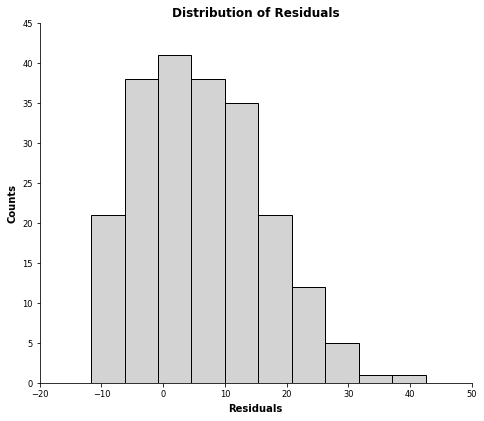

In [56]:
normal_errors_assumption(tr, X.to_numpy(), y.to_numpy())